# Imports

In [1]:
from utils import *
from paths_and_parameters import *

#### To reset results, delete output folders.
WARNING: every previous result will be lost. Use only if you want to delete all files in the data folders

In [2]:
do_you_want_to_delete = False

if do_you_want_to_delete:
    if isdir(path_figures):
        rmtree(path_figures)
    if isdir(path_results):
        rmtree(path_results)
    if isdir(path_database_exp):
        rmtree(path_database_exp)

#### Check if output folders exist. If not, create them.

In [3]:
if not isdir(path_figures):
    makedirs(path_figures)
if not isdir(path_results):
    makedirs(path_results)
if not isdir(path_database_exp):
    makedirs(path_database_exp)

# Read XRD Data and Database
To recalculate h5 file, change just for one time the filename that the cell tries to read (indicated by the comment)

In [4]:
%matplotlib inline
rcParams['font.size'] = 12

try:
    data = DataXRD().load_h5(path_xrd + 'xrd.h5') # to force the recalculation of h5 file, change this filename
    if any(not hasattr(data, attr) for attr in data.check_attributes):
        print('The present h5 file doesn\'t have all required information. Reading from raw data.')
        data = read_raw_XRD(path_xrd)
except:
    print('Reading from raw data.')
    data = read_raw_XRD(path_xrd)

y_x_ratio = data.shape[0] / data.shape[1]
print(f'Shape of data: {data.shape}')
print('Initial calibration:')
print(f'a = {data.opt[0]:.1f}, s = {data.opt[1]:.1f}, beta = {data.opt[2]:.3f}')
print(f'Theta range {list(data.fce_calibration([0, data.shape[2]], *data.opt))}')

database = DatabaseXRD().read_cifs(path_database)
print('\nPhases in database:', len(database))

Loading: ../../shared/dataXRDXRF/MunchMuseum/M491/ProfiloXRD/xrd.h5
Shape of data: (95, 170, 1280)
Initial calibration:
a = -1214.7, s = 1952.7, beta = 51.663
Theta range [19.77907407899562, 53.578190550653794]

Phases in database: 366


### Correct burnt pixels
Substitute burnt pixel with the average of the non burnt ones.

In [5]:
qtl = 0.999

data_max = (data.data - data.background).max(axis = 2)
indices_to_correct = data_max > quantile(data_max, qtl)

data.data[indices_to_correct] = data.data[~indices_to_correct].mean(axis = 0, keepdims = True)
data.background[indices_to_correct] = data.background[~indices_to_correct].mean(axis = 0, keepdims = True)
data.intensity[indices_to_correct] = data.intensity[~indices_to_correct].mean(axis = 0, keepdims = True)
data.signal_background_ratio[indices_to_correct] = data.signal_background_ratio[~indices_to_correct].mean(axis = 0, keepdims = True)
data.rescaling[indices_to_correct] = data.rescaling[~indices_to_correct].mean(axis = 0, keepdims = True)

print(f'{indices_to_correct.sum()} pixels out of {data.shape[0] * data.shape[1]} were corrected.')

17 pixels out of 16150 were corrected.


# Read XRF maps

If the orientation of tiff images does not correspond with XRD scans, flip them in this cell

In [6]:
data_xrf = DataXRF()
data_xrf.read_tiff(path_xrf)
data_xrf.labels = flip(data_xrf.labels, axis = [1]) # choose the axes to flip
print(f'Found {data_xrf.labels.shape[2]} images')

Found 24 images


### Correct burnt pixels and wrong scale in each XRF map
Choose a quantile on the value of XRF intensity. All pixels above that quantile will be corrected as burnt pixels and will be assigned the threshold value.

In [7]:
qtl = 0.999
#qtl = 1

qtl_calculated = quantile(data_xrf.labels, qtl, axis = (0, 1))[newaxis, newaxis, :]
n_corrected = (data_xrf.labels > qtl_calculated).sum() / data_xrf.labels.shape[-1]
data_xrf.labels = clip(data_xrf.labels, None, qtl_calculated)
print(f'{n_corrected:.0f} pixels out of {data_xrf.labels.shape[0] * data_xrf.labels.shape[1]} were corrected on average in each XRF map.')

data_xrf.labels -= data_xrf.labels.min(axis = (0, 1), keepdims = True)

17 pixels out of 16150 were corrected on average in each XRF map.


# Select primary phases

### Manually select them

In [8]:
hydrocerussite = database['Hydrocerussite'][0]
lazurite = database['Lazurite'][0]
cinnabar = database['Cinnabar'][1]

phases_primary = [hydrocerussite, lazurite, cinnabar]

### Take them from file `phases_selection_primary.dat`

In [9]:
phases_primary = phases_from_file('phases_selection_primary.dat', database)

Loaded phases: Fe2 O3 1, Goethite 10, Hematite 9, Siderite 1


# Search for primary phases

### Change initial calibration

In [9]:
#data.opt = array([-1208.08149362, 1948.24846333, 51.66346438])

### Create data structure

In [10]:
gm = GammaMap().from_data(data, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)

### Autocalibration and search
Optimizes on $a,s$ and $\gamma$. Choses the best phase by overlap area and fits with respect to that.

In [11]:
%%time
gm = gm.search()
L1loss, MSEloss, overlap_area = gm.metrics()

Using 8 CPUs
Using 8 CPUs
CPU times: user 11.1 s, sys: 1.72 s, total: 12.8 s
Wall time: 16.5 s


#### Fast mapping

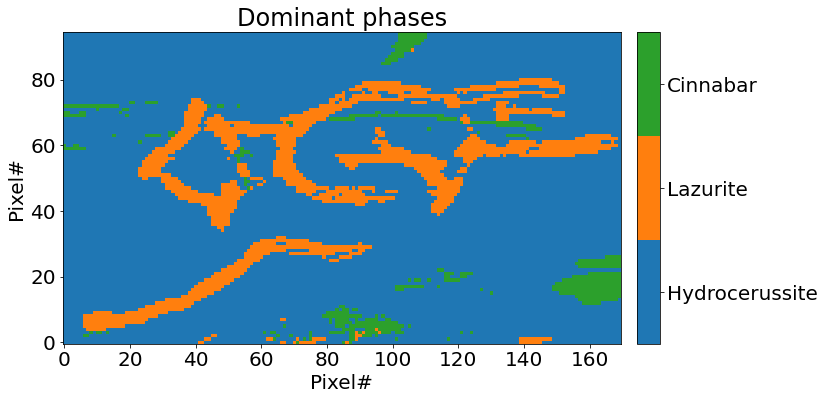

In [12]:
%matplotlib inline
rcParams['font.size'] = 20

fig, ax = subplots(figsize = (10, 6))
cmap_chosen = get_cmap('tab10')
norm_chosen = BoundaryNorm(arange(-0.5, len(gm.phases) + 0.5, 1), len(gm.phases))
im = imshow(gm.selected(), interpolation = 'none', cmap = cmap_chosen, norm = norm_chosen)
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_ticks(range(0, len(gm.phases)))
cbar.set_ticklabels([p.label for p in gm.phases])
ax.set_title('Dominant phases')
ax.set_xlabel(r'Pixel#')
ax.set_ylabel(r'Pixel#')

savefig(path_figures + 'fast_map_dominant_phases.png', bbox_inches = 'tight', dpi = 200)
show()

# Quantify phase presence

In [13]:
correction = data.rescaling**0.5
criterion = overlap_area * correction

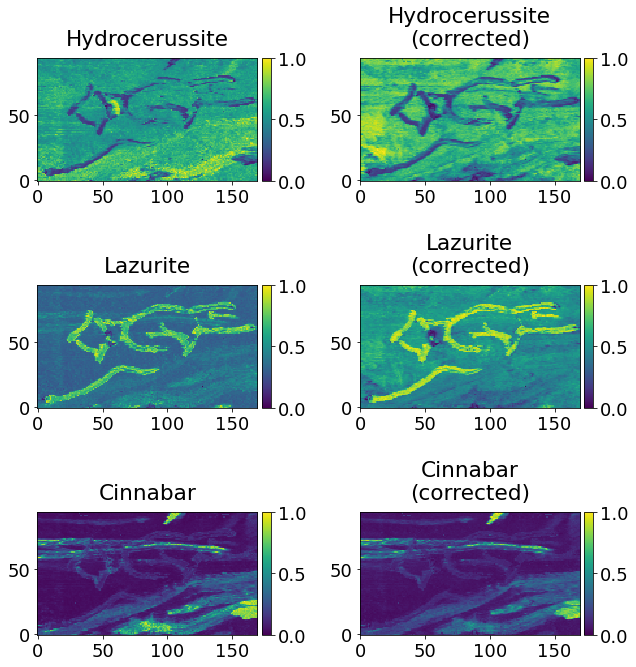

In [14]:
%matplotlib inline
rcParams['font.size'] = 18
position_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm.phases):
    if (len(gm.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:        

            if (len(gm.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none')
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion[..., i] / criterion[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(position_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Save maps as PNG and TIF

In [15]:
rcParams['font.size'] = 14

value_max = nanmax(nanmax(criterion, axis = 0, keepdims = True), axis = 1, keepdims = True)
matrix_plot = criterion / value_max
matrix_components_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])

for idx_phase, phase in enumerate(gm.phases):
    fig, ax = subplots(figsize = (5, 3))
    im = imshow(matrix_plot[..., idx_phase], interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_title(phase.label)
    fig.set_dpi(80)
    savefig(path_figures + 'primary - ' + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + 'primary - ' + phase.label + '.tiff')
    img.save(path_figures + 'primary - ' + phase.label + '.png')

    close(fig)

# Explore one pixel with fitted primary phases

,XRF element,XRF intensity,Phase,Phase presece,Phase overlap,"(x, y)"
0,Pb_L,0.869,Hydrocerussite,0.966,0.549,"(14, 23)"


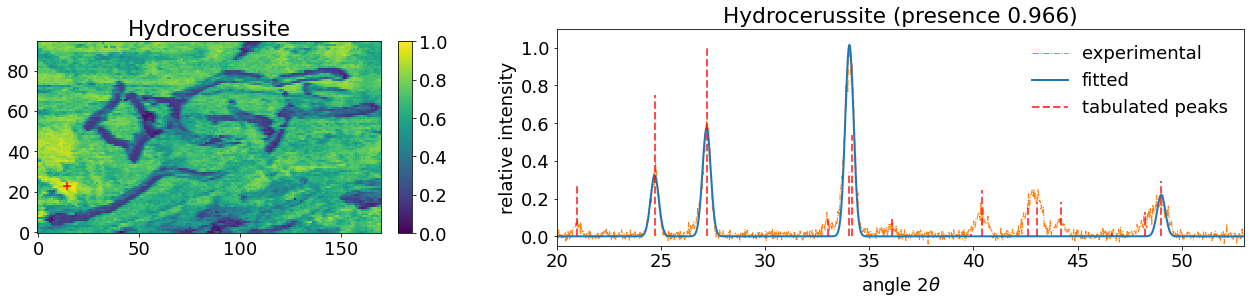

In [25]:
rcParams['font.size'] = 18

elements_chosen = ['Pb'] # Only phases with these elements will be selected

#selection_of_x_y = 'manual'               # Manually select the pixel
#selection_of_x_y = 'from XRF'             # Automatically select the pixel in which the first element chosen has maximum XRF intensity
selection_of_x_y = 'from phase presence'  # Automatically select for each phase the pixel in which the phase has maximum presence
n_th_best_pixel = 10

x, y = 20, 40

selection_phases = zeros(len(gm.phases), dtype = bool)
for i, phase in enumerate(gm.phases):
    if '_chemical_formula_sum' in phase:
        if all(e in phase['_chemical_formula_sum'] for e in elements_chosen):
            selection_phases[i] = True

i_element = find_element(elements_chosen[0], data_xrf.metadata['labels'])
map_xrf = data_xrf.labels[..., i_element] / nanmax(data_xrf.labels[..., i_element])
presence_max = nanmax(nanmax(criterion, axis = 0, keepdims = True), axis = 1, keepdims = True)
maps_phase_presence = criterion / presence_max

df_stats = DataFrame(columns = ['XRF element', 'XRF intensity', 'Phase', 'Phase presece', 'Phase overlap', '(x, y)'])

if selection_of_x_y == 'from XRF':
    position = flip(map_xrf.flatten().argsort())[n_th_best_pixel]
    y, x = unravel_index(position, map_xrf.shape)
    fig, ax = subplots(figsize = (12, 12 * y_x_ratio))
    ax.imshow(map_xrf, interpolation = 'none')
    ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
    ax.set_title('XRF ' + data_xrf.metadata['labels'][i_element] + f'\nIntensity {map_xrf[y, x]:.3f} in {(x, y)}')
    show()

fig, axs = subplots(selection_phases.sum(), 2, figsize = (18, 4*selection_phases.sum()),
                   gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(gm.phases):
    if selection_phases[i]:

        if selection_of_x_y == 'from phase presence':
            position = flip(maps_phase_presence[..., i].flatten().argsort())[n_th_best_pixel]
            y, x = unravel_index(position, maps_phase_presence[..., i].shape)
            
        g = gm.get_pixel(x, y)[i]
        if (selection_phases.sum() > 1):
            ax = axs[i, 0]
        else:
            ax = axs[0]
        sca(ax)
        im = imshow(maps_phase_presence[..., i], interpolation = 'none', vmin = 0)
        cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
        #cbar.set_label('overlap')
        scatter(x, y, s = 50, c = 'red', marker = '+')
        ax.set_title(phase.label)

        if (selection_phases.sum() > 1):
            ax = axs[i, 1]
        else:
            ax = axs[1]
        sca(ax)
        g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
        g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
        #g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
        g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
        ax.set_xlim(min_theta, max_theta)
        ax.set_ylim(-0.05, 1.1)
        ax.set_xlabel(r'angle $2\theta$')
        ax.set_ylabel(r'relative intensity')
        ax.set_title(f'{phase.label} (presence {maps_phase_presence[y, x, i]:.3f})')
        ax.legend(frameon = False)
        df_stats.loc[len(df_stats)] = [
            data_xrf.metadata['labels'][i_element], map_xrf[y, x], phase.label, maps_phase_presence[y, x, i], g.overlap_area_ratio(), (x, y)
        ]

display(df_stats.style.format({'XRF intensity': '{:.3f}', 'Phase presece': '{:.3f}', 'Phase overlap': '{:.3f}'}))
show()

# Select secondary phases

### Manually select them

In [16]:
bone_black = database['Bone_Black'][0]
goethite = database['Goethite'][0]
hematite = database['Hematite'][4]
yellow_cd_zn_s = database['Cadmium zinc sulphide yellow'][0]

phases_secondary = [bone_black, goethite, hematite, yellow_cd_zn_s]

### Take them from file `phases_selection_secondary.dat`

In [19]:
phases_secondary = phases_from_file('phases_selection_secondary.dat', database)

Loaded phases: Jarosite 15, Pyrite 4


# Search for secondary phases

### Smooth data

In [17]:
step = 2
method = 'mean'
#method = 'max'

data_smooth = data.generate_smooth(step, method)

Generating smooth data...
Removing background...
Done.
Done.


### Check rescaling factor

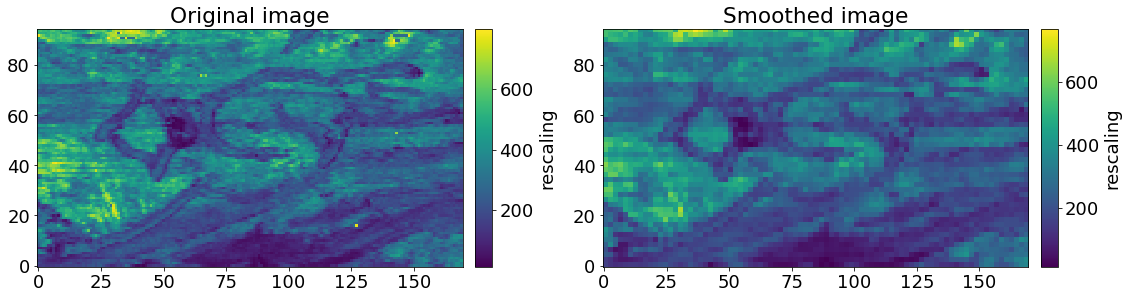

In [18]:
rcParams['font.size'] = 18

fig, axs = subplots(1, 2, figsize = (15, 6))
fig.tight_layout(w_pad = 5)

ax = axs[0]
im = ax.imshow(data.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Original image')

ax = axs[1]
im = ax.imshow(data_smooth.rescaling.squeeze(), interpolation = 'none')
cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.03, 0, 0.04, 1]))
cbar.set_label('rescaling')
ax.set_title('Smoothed image')

show()

### Refit primary phases on smoothed data

In [19]:
%%time

gm1 = GammaMap().from_data(data_smooth, phases_primary, sigma = sigma, min_theta = min_theta, max_theta = max_theta,
    min_intensity = min_intensity, first_n_peaks = first_n_peaks)
gm1 = gm1.search()
overlap_area_1 = gm1.overlap_area()

Using 8 CPUs
CPU times: user 13.5 s, sys: 1.67 s, total: 15.1 s
Wall time: 16.7 s


### Fit secondary phases on smoothed data

You can choose how many peaks to consider in secondary phases

In [20]:
%%time

first_n_peaks_secondary = 3

gm2 = GammaMap_Secondary().from_data(gm1, data_smooth, phases_secondary, sigma = sigma, min_theta = min_theta,
    max_theta = max_theta, min_intensity = min_intensity, first_n_peaks = first_n_peaks_secondary)
gm2 = gm2.fit_cycle(steps = 6, gamma = True)
overlap_area_difference_ratio_2 = gm2.overlap_area_difference()

Using 8 CPUs
CPU times: user 18.9 s, sys: 4.67 s, total: 23.6 s
Wall time: 24.7 s


### Quantify phase presence

In [21]:
correction = data_smooth.rescaling**0.5
criterion_1 = overlap_area_1 * correction
criterion_2 = overlap_area_difference_ratio_2 * correction

# Plots

### Primary phases

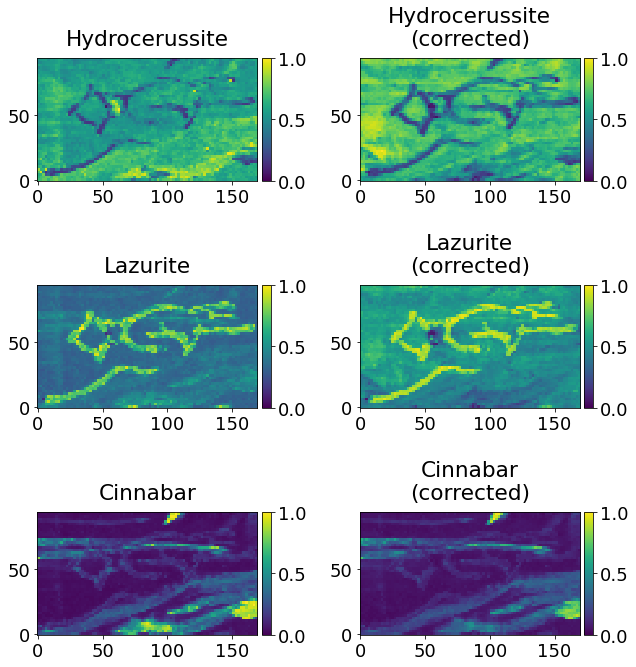

In [22]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm1.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm1.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm1.phases):
    if (len(gm1.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area_1[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm1.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion_1[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:

            if (len(gm1.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm1.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion_1[..., i] / criterion_1[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Secondary phases

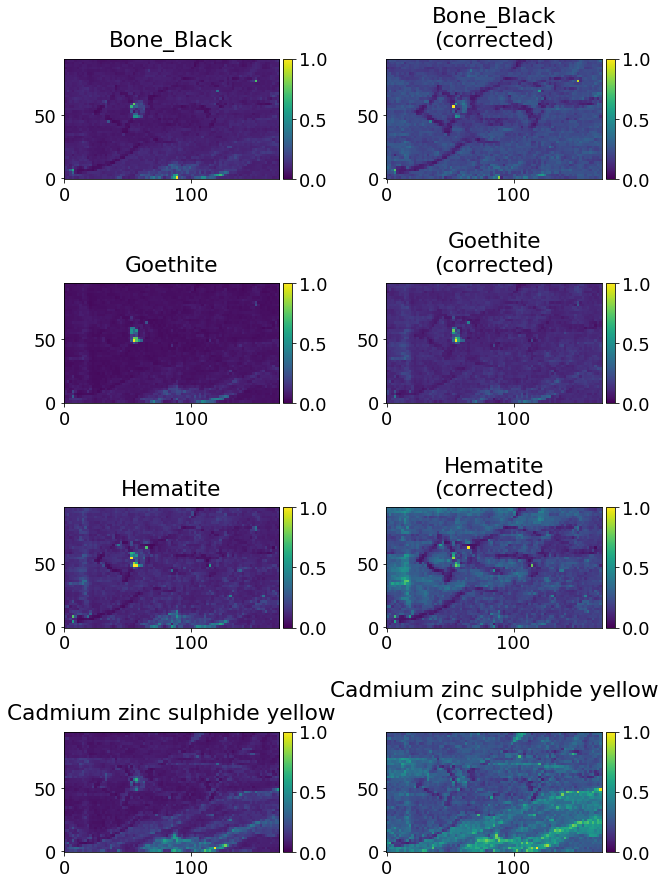

In [23]:
%matplotlib inline
rcParams['font.size'] = 18
settings_colorbar = [1.02, 0, 0.04, 1]
include_xrf_filter = False

if include_xrf_filter:
    n_cols = 4
else:
    n_cols = 2
fig, axs = subplots(len(gm2.phases), n_cols, figsize = (4.5 * n_cols, 3 * len(gm2.phases)))
fig.tight_layout(h_pad = 4, w_pad = 2)

for i, phase in enumerate(gm2.phases):
    if (len(gm2.phases) > 1):
        ax = axs[i, 0]
    else:
        ax = axs[0]
    matrix_plot = overlap_area_difference_ratio_2[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label, y = 1.05)
    
    if (len(gm2.phases) > 1):
        ax = axs[i, 1]
    else:
        ax = axs[1]
    matrix_plot = criterion_2[..., i].copy()
    matrix_plot /= nanmax(matrix_plot)
    im = ax.imshow(matrix_plot, interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
    ax.set_title(phase.label + '\n(corrected)', y = 1.05)
    
    if include_xrf_filter:
        indices_associated_elements = []
        if 'associated elements' in phase.keys():
            print(phase.label + ': ' + ', '.join(phase['associated elements']))
            for element in phase['associated elements']:
                j = find_element(element, data_xrf.metadata['labels'], allow_loose = False)
                if j is None:
                    print(phase.label + ': ' + phase['associated element'] + ' not found')
                else:
                    indices_associated_elements.append(j)
        if indices_associated_elements:     

            if (len(gm2.phases) > 1):
                ax = axs[i, 2]
            else:
                ax = axs[2]
            map_xrf = data_xrf.labels[..., indices_associated_elements].min(axis = -1)
            im = ax.imshow(map_xrf, interpolation = 'none', vmin = 0, vmax = None)
            formatter = ScalarFormatter(useMathText = True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-2, 2))
            cb = colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar), format = formatter)
            cb.ax.yaxis.set_offset_position('left')
            ax.set_title('\n'.join([data_xrf.metadata['labels'][idx] for idx in indices_associated_elements]), y = 1.05)

            if (len(gm2.phases) > 1):
                ax = axs[i, 3]
            else:
                ax = axs[3]
            map_xrd = criterion_2[..., i] / criterion_2[..., i].max()
            map_xrf = map_xrf / map_xrf.max()
            map_xrd_corrected = map_xrd * map_xrf
            map_xrd_corrected /= map_xrd_corrected.max()
            im = ax.imshow(map_xrd_corrected, interpolation = 'none', vmin = 0)
            colorbar(im, ax = ax, cax = ax.inset_axes(settings_colorbar))
            ax.set_title(phase.label + '\n(corrected and filtered)', y = 1.05)

show()

### Save maps of secondary phases as PNG and TIF

In [42]:
rcParams['font.size'] = 18

value_max = nanmax(nanmax(criterion_2, axis = 0, keepdims = True), axis = 1, keepdims = True)
matrix_plot = criterion_2 / value_max
matrix_components_tiff = flip((matrix_plot * 65535).astype('uint16'), axis = [0])

for idx_phase, phase in enumerate(gm2.phases):
    fig, ax = subplots(figsize = (5, 3))
    ax.set_title(phase.label)
    im = imshow(matrix_plot[..., idx_phase], interpolation = 'none', vmin = 0)
    colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
    ax.set_yticks([])
    ax.set_xticks([])
    fig.set_dpi(80)
    savefig(path_figures + 'secondary - ' + phase.label + ' - criterion.png',
                bbox_inches = 'tight', dpi = 600)

    img = Image.fromarray(matrix_components_tiff[..., idx_phase])
    img.save(path_results + 'secondary - ' + phase.label + '.tiff')
    img.save(path_figures + 'secondary - ' + phase.label + '.png')

    close(fig)

# Verify overlap of secondary phases in chosen pixel

### List of secondary phases

In [43]:
DataFrame({
    'Phase': [p.label for p in phases_secondary],
    'Chemical formula': [p['_chemical_formula_sum'] if '_chemical_formula_sum' in p.keys() else '-' for p in phases_secondary]
})

,Phase,Chemical formula
0,Bone_Black,-
1,Goethite,Fe H O2
2,Hematite,Fe2 O3
3,Cadmium zinc sulphide yellow,Cd Zn S


Primary phases: 0.644 of experimental area
Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases
Goethite:	0.031
Hematite:	0.040
Cadmium zinc sulphide yellow:	0.013


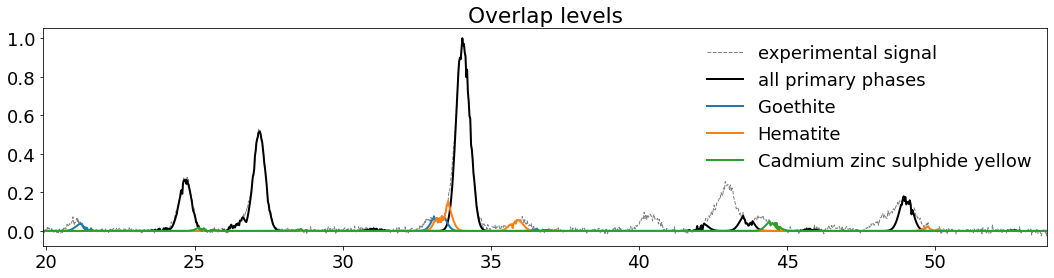

In [26]:
#x, y = 20, 80
rcParams['font.size'] = 18

elements_allowed = ['Fe', 'Cd']

selection_phases = zeros(len(phases_secondary), dtype = bool)
for i, phase in enumerate(phases_secondary):
    if '_chemical_formula_sum' in phase:
        if any(e in phase['_chemical_formula_sum'] for e in elements_allowed):
            selection_phases[i] = True

gs2 = gm2.get_pixel(x, y)

fig, ax = subplots(figsize = (18, 4))
theta = gs2.gammasearch_1[0].theta
ax.plot(theta, gs2.intensity, c = 'grey', ls = '--', lw = 1, label = 'experimental signal')
ax.plot(theta, gs2.gammasearch_1.overlap_total(), c = 'black', ls = '-', lw = 2, label = 'all primary phases')
print(f'Primary phases: {gs2.gammasearch_1.overlap_total_ratio():.3f} of experimental area')
print('Secondary phases – Fraction of experimental area covered by each secondary phase but not by primary phases')
for j in range(len(gs2)):
    if selection_phases[j]:
        ax.plot(theta, gs2.overlap()[j], ls = '-', lw = 2, label = gs2[j].phase.label)
        print(f'{gs2[j].label}:\t{gs2.overlap_area_difference_ratio()[j]:.3f}')

legend(frameon = False)
ax.set_xlim(theta[0], theta[-1])
ax.set_title('Overlap levels')
show()

# Explore one pixel with fitted secondary phases

,XRF element,XRF intensity,Phase,Phase presece,Phase overlap,"(x, y)"
0,Pb_L,0.869,Hydrocerussite,0.966,0.549,"(14, 23)"


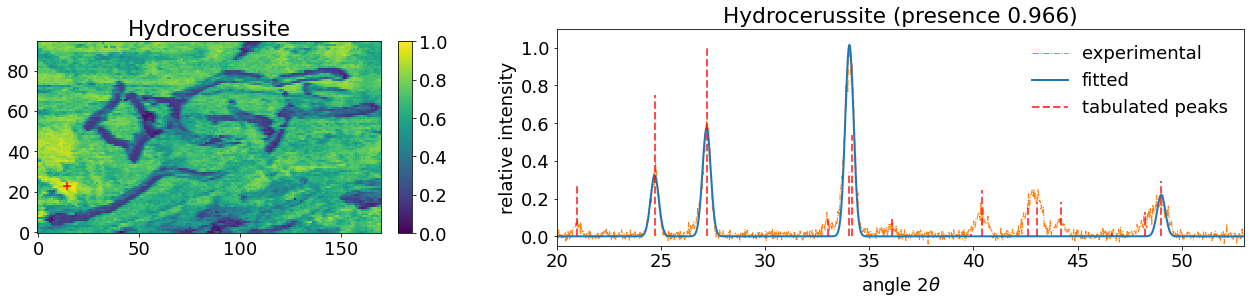

In [15]:
rcParams['font.size'] = 18

elements_chosen = ['Pb'] # Only phases with these elements will be selected

#selection_of_x_y = 'manual'               # Manually select the pixel
#selection_of_x_y = 'from XRF'             # Automatically select the pixel in which the first element chosen has maximum XRF intensity
selection_of_x_y = 'from phase presence'  # Automatically select for each phase the pixel in which the phase has maximum presence
n_th_best_pixel = 10

x, y = 20, 40

selection_phases = zeros(len(gm.phases), dtype = bool)
for i, phase in enumerate(gm.phases):
    if '_chemical_formula_sum' in phase:
        if all(e in phase['_chemical_formula_sum'] for e in elements_chosen):
            selection_phases[i] = True

i_element = find_element(elements_chosen[0], data_xrf.metadata['labels'])
map_xrf = data_xrf.labels[..., i_element] / nanmax(data_xrf.labels[..., i_element])
presence_max = nanmax(nanmax(criterion, axis = 0, keepdims = True), axis = 1, keepdims = True)
maps_phase_presence = criterion / presence_max

df_stats = DataFrame(columns = ['XRF element', 'XRF intensity', 'Phase', 'Phase presece', 'Phase overlap', '(x, y)'])

if selection_of_x_y == 'from XRF':
    position = flip(map_xrf.flatten().argsort())[n_th_best_pixel]
    y, x = unravel_index(position, map_xrf.shape)
    fig, ax = subplots(figsize = (12, 12 * y_x_ratio))
    ax.imshow(map_xrf, interpolation = 'none')
    ax.scatter(x, y, s = 100, lw = 2, marker = 'o', edgecolors = 'red', facecolors = 'none')
    ax.set_title('XRF ' + data_xrf.metadata['labels'][i_element] + f'\nIntensity {map_xrf[y, x]:.3f} in {(x, y)}')
    show()

fig, axs = subplots(selection_phases.sum(), 2, figsize = (18, 4*selection_phases.sum()),
                   gridspec_kw = {'width_ratios': [1, 2]})
fig.tight_layout(h_pad = 5, w_pad = 7)

for i, phase in enumerate(gm.phases):
    if selection_phases[i]:

        if selection_of_x_y == 'from phase presence':
            position = flip(maps_phase_presence[..., i].flatten().argsort())[n_th_best_pixel]
            y, x = unravel_index(position, maps_phase_presence[..., i].shape)
            
        g = gm.get_pixel(x, y)[i]
        if (selection_phases.sum() > 1):
            ax = axs[i, 0]
        else:
            ax = axs[0]
        sca(ax)
        im = imshow(maps_phase_presence[..., i], interpolation = 'none', vmin = 0)
        cbar = colorbar(im, ax = ax, cax = ax.inset_axes([1.05, 0, 0.04, 1]))
        #cbar.set_label('overlap')
        scatter(x, y, s = 50, c = 'red', marker = '+')
        ax.set_title(phase.label)

        if (selection_phases.sum() > 1):
            ax = axs[i, 1]
        else:
            ax = axs[1]
        sca(ax)
        g.plot_spectrum(c = 'tab:orange', ls = '-.', lw = 1, label = 'experimental')
        g.plot(c = 'tab:blue', ls = '-', lw = 2, label = 'fitted')
        #g.phase.plot(color = 'k', lw = 1, lineheight = 1, alpha = 0.3, label = '')
        g.phase.plot(color = 'r', lw = 2, alpha = 0.7, label = 'tabulated peaks')
        ax.set_xlim(min_theta, max_theta)
        ax.set_ylim(-0.05, 1.1)
        ax.set_xlabel(r'angle $2\theta$')
        ax.set_ylabel(r'relative intensity')
        ax.set_title(f'{phase.label} (presence {maps_phase_presence[y, x, i]:.3f})')
        ax.legend(frameon = False)
        df_stats.loc[len(df_stats)] = [
            data_xrf.metadata['labels'][i_element], map_xrf[y, x], phase.label, maps_phase_presence[y, x, i], g.overlap_area_ratio(), (x, y)
        ]

display(df_stats.style.format({'XRF intensity': '{:.3f}', 'Phase presece': '{:.3f}', 'Phase overlap': '{:.3f}'}))
show()